<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

# Point Mutation Scan between Antigen and Antibody

The purpose of this section is to create a protocol that prepares an antibody-antigen bound structure, makes point mutations on the antibody, records change in binding enregy, and generates a heatmap displaying the energy differences. This method is widely used in antibody interface design for  improving binding affinity. The whole protocol is outlined by the following eight steps.

**Step 1.** Prepare the structure with FastRelax()

**Step 2.** Generate a resfile with write_resfile()

**Step 3.** Get neighbors of mutated residues with get_neighbors()

**Step 4.** Perform the mutation with PackMover()

**Step 5.** Generate unbound  antibody and antigen structres with ubind()

**Step 6.** Get wildtype amino acid

**Step 7.** Mutate and pack a specific residue and output energy metrics

**Step 8.** Loop through interface positions mutating them into 20 amino acids with output files

**Step 9.** Summarize all input files for binding energy analysis

Keywords:

## Overview

#### Setup the Notebook

In [0]:
# Notebook setup
import sys
if 'google.colab' in sys.modules:
    !pip install pyrosettacolabsetup
    import pyrosettacolabsetup
    pyrosettacolabsetup.setup()
    print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).
Notebook is set for PyRosetta use in Colab.  Have fun!
Mounted at /content/google_drive


**Make sure you are in the directory with the pdb files:**

`cd google_drive/My\ Drive/student-notebooks/`

### Loading structure your structure

In [0]:
from pyrosetta import * 
init()
pose = pose_from_pdb("inputs/1jhl.clean.pdb")
testPose = Pose()
testPose.assign(pose)
print(testPose)

PyRosetta-4 2019 [Rosetta PyRosetta4.MinSizeRel.python36.linux 2019.38+release.f3cd88e4837a35eba6d19fd9c30ebf5748c77cae 2019-09-18T23:40:11] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python36.linux r232 2019.38+release.f3cd88e f3cd88e4837a35eba6d19fd9c30ebf5748c77cae http://www.pyrosetta.org 2019-09-18T23:40:11
core.init: command: PyRosetta -ex1 -ex2aro -database /content/google_drive/My Drive/KulpLab/PyRosetta/prefix/pyrosetta-2019.38+release.f3cd88e-py3.6-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-887777121 seed_offset=0 real_seed=-887777121
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-887777121 RG_type=mt19937
core.import_pose.import_pose: File 'inputs/1jhl.c

### **Step 1.** Prepare the starting structure with FastRelax()

Properly relaxing a structure is crucial in design with Rosetta. A non-relaxed structure may have interactions causing a large positive energy and therefore skew the following analysis on binding energy.

FastRelax() is used to relax the structrue. While we want to put the sturcture in its lowest energy state, we want to keep the backbone information from the crystal structure as much as possible (lowest RMSD). Therefore, we apply constrain_relax_to_start_coords(True) to FastRelax().

Since FastRelax() is taking up a huge amount of resources, running it may crash the notebook, we commented out the "apply" part (the part that performs the relax). We uploaded the relaxed structure to the input folder for furthre analysis.



In [0]:
from pyrosetta.rosetta.protocols.relax import FastRelax

relax = FastRelax()
scorefxn = get_fa_scorefxn()
relax.set_scorefxn(scorefxn)
relax = rosetta.protocols.relax.FastRelax()
relax.constrain_relax_to_start_coords(True)
print(relax)
#relax.apply(testPose)
#testPose.dump_pdb('test.relax.pdb')

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015


### Writing Function in Python

A function is a good way to organize your code. Starting from this section I am introducing serveral helper functions to facilitate the protocol.

To define a function in python, a "def" key word is used. A function can either return a value or simply execute code blocks. A defined function can be called in a main function or other sections of code.

 ## **Step 2.** get_neighbors()

get_neighbors() returns a dictionary containing position information and resfile commands needs to be written in a resfile. A dictionary can be defined in python with sytax {A:B}. More information can be found in the following link https://www.w3schools.com/python/python_dictionaries.asp

A "resfile" will be introduced in more detail in the next write_resfile() function.

In [0]:
from pyrosetta.rosetta.protocols.geometry import *
def get_neighbors(pose, posi):
    NEIGHBOR_CUTOFF = 6
    neighb = {}
    for i in range (1, pose.total_residue()+ 1):
        if((center_of_mass(pose,posi,posi)-center_of_mass(pose,i,i)).norm()<NEIGHBOR_CUTOFF):
            neighb.update({i: ' NATAA'})
    return neighb

relaxPose = pose_from_pdb("inputs/1jhl.relax.pdb")
print(get_neighbors(relaxPose, 130))


core.import_pose.import_pose: File 'inputs/1jhl.relax.pdb' automatically determined to be of type PDB
core.conformation.Conformation: Found disulfide between residues 230 351
core.conformation.Conformation: current variant for 230 CYS
core.conformation.Conformation: current variant for 351 CYS
core.conformation.Conformation: current variant for 230 CYD
core.conformation.Conformation: current variant for 351 CYD
core.conformation.Conformation: Found disulfide between residues 130 204
core.conformation.Conformation: current variant for 130 CYS
core.conformation.Conformation: current variant for 204 CYS
core.conformation.Conformation: current variant for 130 CYD
core.conformation.Conformation: current variant for 204 CYD
core.conformation.Conformation: Found disulfide between residues 23 88
core.conformation.Conformation: current variant for 23 CYS
core.conformation.Conformation: current variant for 88 CYS
core.conformation.Conformation: current variant for 23 CYD
core.conformation.Confor

## **Step 3.** write_resfile()

A "resfile" is an instruction set for the PackMover() in order to perform packing and design on certain regions of the input structure. A resfile is made up by a header and body. Header conmands apply to whole structure while body commands usually apply to a specific region. Syntax and conventions about a Resfile can be found here. https://www.rosettacommons.org/docs/latest/rosetta_basics/file_types/resfiles

Note: In a resfile, it is important to include the input file rotamer in its sampling space (USE_INPUT_SC), because the Rosetta Rotamer Library may not contain a side chain with a simliar conformation to that found in the starting crystal structure. It should be possible to put "USE_INPUT_SC" in the resfile header, however we found at the time of writing that it is neccessary to put USE_INPUT_SC in each line of the resfile body. 

In [0]:
def write_resfile(pose, resfilename, pack = True, design = False,
         input_sc = True, freeze = [], specific = {}):
  
    SEARCH_LEVEL = "EX 1 LEVEL 1 EX 2 LEVEL 1 " #For time saving, in real work
                                                #we typically have "EX 1 LEVEL 4 EX 2 LEVEL 4 EX3 EX4 "

    # determine the header, default settings
    header = ''
    if pack:
        if not design:
            header += 'NATAA\n'
        else:
            header += 'ALLAA\n# ALLAA will NOT work on bridged Cysteines\n'
    else:
        header += 'NATRO\n'
    if input_sc:
        header += 'USE_INPUT_SC\n'
    to_write = header + 'start\n'
    # add  <freeze>  list to  <specific>  dict
    for i in freeze:
        specific[i] = 'NATRO'
    #  <specific>  is a dictionary with keys() as pose resi numbers
    #    and values as resfile keywords (PIKAA
    # use PDBInfo object to write the resfile
    info = pose.pdb_info()
    # pose_from_sequence returns empty PDBInfo, Pose() makes NULL
    if info and info.nres():
        for i in specific.keys():
            num = pose.pdb_info().number(i)
            chain = pose.pdb_info().chain(i)

            #Write
            to_write += (str(num).rjust(4) + str(chain).rjust(3) + '  ' + 
                         specific[i] + ' USE_INPUT_SC ' + 
                         SEARCH_LEVEL + 'EX_CUTOFF 1' + '\n')

    
    else:
        for i in specific.keys():
            num = i
            chain = ' '
            to_write += (str(num).rjust(4) + str(chain).rjust(3) + '  ' + 
                         specific[i] + ' USE_INPUT_SC ' + 
                         SEARCH_LEVEL + 'EX_CUTOFF 1' + '\n')

    f = open(resfilename,'w+')
    f.write(to_write)
    f.close()

relaxPose = pose_from_pdb("inputs/1jhl.relax.pdb")
resfilename = "resfile_130"
specific = get_neighbors(relaxPose, 130)
write_resfile(relaxPose, resfilename, specific)


core.import_pose.import_pose: File 'inputs/1jhl.relax.pdb' automatically determined to be of type PDB
core.conformation.Conformation: Found disulfide between residues 230 351
core.conformation.Conformation: current variant for 230 CYS
core.conformation.Conformation: current variant for 351 CYS
core.conformation.Conformation: current variant for 230 CYD
core.conformation.Conformation: current variant for 351 CYD
core.conformation.Conformation: Found disulfide between residues 130 204
core.conformation.Conformation: current variant for 130 CYS
core.conformation.Conformation: current variant for 204 CYS
core.conformation.Conformation: current variant for 130 CYD
core.conformation.Conformation: current variant for 204 CYD
core.conformation.Conformation: Found disulfide between residues 23 88
core.conformation.Conformation: current variant for 23 CYS
core.conformation.Conformation: current variant for 88 CYS
core.conformation.Conformation: current variant for 23 CYD
core.conformation.Confor

### **Step 4.** perform the mutation
This function is carried out by PackMover(). Functions defined in previous steps are used here to modify and write the resfile.

In [0]:
from pyrosetta.rosetta.core.pack.task import *
from pyrosetta.rosetta.protocols import *

def pack(pose, posi, amino, resfile, scorefxn):
    #Generate Design
    specific_design = get_neighbors(pose, posi)
    specific_design[posi] = 'PIKAA ' + str(amino)
    #specific_design = {posi: 'PIKAA '+' '+str(amino)}
    write_resfile(pose, resfile, 
        pack = False, design = False , specific = specific_design)
            
    #Perform The Move
    task_design = TaskFactory.create_packer_task(pose)
    rosetta.core.pack.task.parse_resfile(pose, task_design, 
        resfile)
    designmover = minimization_packing.PackRotamersMover(scorefxn, task_design)
    designmover.apply(pose)

relaxPose = pose_from_pdb("inputs/1jhl.relax.pdb")
resfile = "resfile"
scorefxn = get_fa_scorefxn()
print("\nOld Energy:", scorefxn(relaxPose),"\n")
pack(relaxPose, 130, 'A', resfile, scorefxn)
print("\nNew Energy:", scorefxn(relaxPose),"\n")
relaxPose = pose_from_pdb("inputs/1jhl.relax.pdb")


core.import_pose.import_pose: File 'inputs/1jhl.relax.pdb' automatically determined to be of type PDB
core.conformation.Conformation: Found disulfide between residues 230 351
core.conformation.Conformation: current variant for 230 CYS
core.conformation.Conformation: current variant for 351 CYS
core.conformation.Conformation: current variant for 230 CYD
core.conformation.Conformation: current variant for 351 CYD
core.conformation.Conformation: Found disulfide between residues 130 204
core.conformation.Conformation: current variant for 130 CYS
core.conformation.Conformation: current variant for 204 CYS
core.conformation.Conformation: current variant for 130 CYD
core.conformation.Conformation: current variant for 204 CYD
core.conformation.Conformation: Found disulfide between residues 23 88
core.conformation.Conformation: current variant for 23 CYS
core.conformation.Conformation: current variant for 88 CYS
core.conformation.Conformation: current variant for 23 CYD
core.conformation.Confor

## **Step 5.** unbind()
This function is for binding energy analysis. To compute a binding energy, we need to score the total energy of a bound state structure as well as the separated (unbound) antigen and antibody. Then, we score the unbound state and the total energy. The binding energy is given by **bound energy** - **unbound energy**.

In [0]:
def unbind(pose, partners):
    STEP_SIZE = 100
    JUMP = 2
    docking.setup_foldtree(pose, partners, Vector1([-1,-1,-1]))
    trans_mover = rigid.RigidBodyTransMover(pose,JUMP)
    trans_mover.step_size(STEP_SIZE)
    trans_mover.apply(pose)

from pyrosetta.rosetta.protocols import *
scorefxn = get_fa_scorefxn()
print("\nBound State Score",scorefxn(relaxPose),"\n")
unbind(relaxPose, "HL_A")
print("\nUnbound State Score", scorefxn(relaxPose),"\n")


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015

Bound State Score -1056.7705984922818 

protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -24.7339 16.9267 23.6626
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517

Unbound State Score -998.7221851693661 



## **Step 6.** wildtype()

An useful metric for evaluating binding improvement is the ratio of mutant binding energy to wild type binding energy. This function returns the wild type amino acids in a given position. 

In [0]:
def wildtype(aatype = 'AA.aa_gly'):
    AA = ['G','A','L','M','F','W','K','Q','E','S','P'
            ,'V','I','C','Y','H','R','N','D','T']

    AA_3 = ['AA.aa_gly','AA.aa_ala','AA.aa_leu','AA.aa_met','AA.aa_phe','AA.aa_trp'
            ,'AA.aa_lys','AA.aa_gln','AA.aa_glu', 'AA.aa_ser','AA.aa_pro','AA.aa_val'
            ,'AA.aa_ile','AA.aa_cys','AA.aa_tyr','AA.aa_his','AA.aa_arg','AA.aa_asn'
            ,'AA.aa_asp','AA.aa_thr']

    for i in range(0, len(AA_3)):
        if(aatype == AA_3[i]):
            return AA[i]

print(wildtype(str(relaxPose.aa(130))))


C


## **Step 7.** Integrate functions for mutate and output

In [0]:
def mutate(pose, posi, amino, partners):
    #main function for mutation
    CSV_PREFIX = 'notec'
    PDB_PREFIX = 'notep'

    #Initiate test pose
    testPose = Pose()
    testPose.assign(pose)

    #Initiate energy function
    scorefxn = get_fa_scorefxn()
    unbind(testPose, partners)
    native_ub = scorefxn(testPose)
    testPose.assign(pose)
    
    #Variables initiation
    content = ''
    resfile = 'rs'+str(posi)+str(amino)
    name = CSV_PREFIX + str(posi)+str(amino) + '.csv'
    pdbname = PDB_PREFIX + str(posi)+str(amino) + '.pdb'
    wt = wildtype(str(pose.aa(posi)))

    pack(testPose, posi, amino, resfile, scorefxn)
    testPose.dump_pdb(pdbname)
    bound = scorefxn(testPose)
    unbind(testPose, partners)
    unbound = scorefxn(testPose)
    binding = unbound - bound
    testPose.assign(pose)

    if (wt == amino):
        wt_energy = binding
    else:
        resfilewt = 'rswt'+str(posi)+str(amino)+str(wt)
        pack(testPose, posi, wt, resfilewt, scorefxn)
        wtbound = scorefxn(testPose)
        unbind(testPose, partners)
        wtunbound = scorefxn(testPose)
        wt_energy = wtunbound - wtbound
        testPose.assign(pose)

    content=(content+str(pose.pdb_info().pose2pdb(posi))+','+str(amino)+','
              +str(native_ub)+','+str(bound)+','+str(unbound)+','+str(binding)+','
              +str(wt_energy)+','+str(wt)+','+str(binding/wt_energy)+'\n')

    f = open(name,'w+')
    f.write(content)
    f.close()

mutate(relaxPose, 130, 'A', 'HL_A')


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
core.pack.rotamer_set.RotamerSet_: [ WARNING ] including current in order to get at least 1 rotamer !!!!!! 130 CYS:disulfide
core.pack.pack_rotamers: built 730 rotamers at 7 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.443 35

## **Step 8.** Loop through interface positions

The following code will loop through all heavy chain and light chain positions mutating them into all 20 amino acids. It is possible to simply output the energy information of each mutation into csv files and concatenate them into one file for future analysis. An output file has been uploaded to the input folder for use in analysis steps below. In a real calculation, parallelization can be utlized by submitting multiple jobs (for loop, each loop will be run on one CPU) in a shell script. For this task, we have a finished version in the inputs folder, so you don't have to run all 20 mutations on all positions within the browser.


In [0]:
import os
os.chdir("./outputs")
os.mkdir("NNK_outputs") #Needs to remove the NNK_outputs folder if ran again
os.chdir("./NNK_outputs")
print(os.getcwd())

for i in [92,85,68,53,5,45,44,42,32,31,22,108,100]:
  print("\nMutating Position: ",str(i),"\n")
  for j in ['G','A','L','M','F','W','K','Q','E','S','P','V','I','C','Y','H','R','N','D','T']:
    mutate(relaxPose, i, j, 'HL_A')

/content/google_drive/My Drive/KulpLab/notebooks/outputs/NNK_outputs

Mutating Position:  92 

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.441 35.3952 153.841
core.pack.pack_rotamers: built 502 rotamers at 6 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
protocols.moves.RigidBodyMover: Translate: Jump (before): RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -100.087 26.161 88.7517
protocols.moves.RigidBodyMover: Translate: Jump (after):  RT 0.552606 0.336448 0.762515 -0.674731 0.717663 0.172329 -0.489249 -0.609723 0.623597 -175.461 35.3687 153.821
core.pack.pack_rotame

Merging output csv files for binding energy analysis in R

In [0]:
import os
#os.chdir("PATH/TO/NNK_outputs")
print(os.getcwd())
cmd = "cat notec* > test_output.csv"
os.system(cmd)
cmd = "scp test_output.csv \"/PATH/TO/inputs\"" # Ex. "scp test_output.csv \"google_drive/My\ Drive/student-notebooks/inputs\""
os.system(cmd)


/content/google_drive/My Drive/KulpLab/notebooks/outputs/NNK_outputs


0

### Loading external library for R functionality

In [0]:
%load_ext rpy2.ipython

Installing related R packages

In [0]:
%%R
setwd("PATH/TO/notebooks/inputs")
install.packages("reshape")
install.packages("ggplot2")
install.packages("tidyr")
install.packages("dplyr")

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/reshape_0.8.8.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 42558 bytes (41 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dis

### R Code for Binding Energy Analysis

After gathering summarized binding energy information, we put that into R for filtering and visualization. From the R code below, we filtered out lower unbound energy structures, those that have higher unbound state total energy than native and make a heatmap from the filtered data. In case you don't want to finish the for loop at Step 8, we uploaded a finished version of merged output csv to the inputs folder named "note_output.csv".


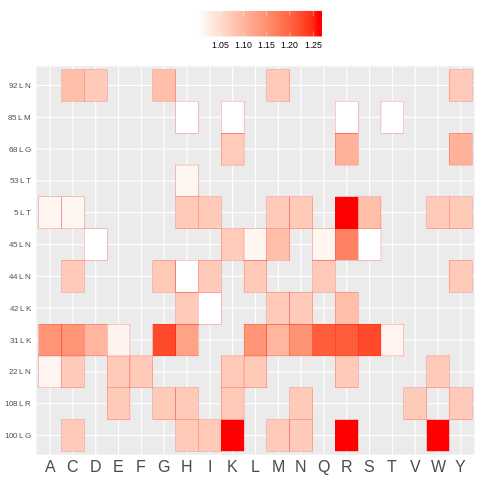

In [0]:
%%R
setwd("/PATH/TO/notebooks/inputs")
library(reshape)
library(ggplot2)
library(tidyr)
library(dplyr)

INPUT_FILE = "test_output.csv"
UNBOUND_CUTOFF = -995
RATIO_CUTOFF = 1
TITLE_COLOR = "red"
HEATMAP_COLOR_LOW = "white"
HEATMAP_COLOR_HIGH = "red"
XLAB_SIZE = 16
YLAB_SIZE = 8
LEGEND_SIZE = 0.9

dat = read.csv(INPUT_FILE, header = TRUE, sep=",")
names(dat) = c("Posi","Amino.Acid","Native","Bound","Unbound","Binding","WT_Binding","WT","Ratio")
dat[,10] = NULL;
dat = separate(dat,Posi,c("Position","Chain"),sep = " ")
dat = mutate(dat,PosiWT = paste(Position,Chain,WT))
dat = dat[dat$Unbound<UNBOUND_CUTOFF,]
dat.m = dat[,c(3,10,11)]
dat.m = dat.m[dat.m$Ratio>RATIO_CUTOFF,]
ggplot(dat.m, aes(Amino.Acid, PosiWT)) + 
  geom_tile(aes(fill = dat.m$Ratio),colour = TITLE_COLOR) + 
  scale_fill_gradient(low = HEATMAP_COLOR_LOW, high = HEATMAP_COLOR_HIGH) +
  xlab("Positions") +
  ylab("Amino Acids") +
  theme(axis.title.x=element_blank(),axis.title.y=element_blank(),
        axis.text.x=element_text(angle=0,family="Helvetica",size=XLAB_SIZE),
        axis.text.y=element_text(family="Helvetica",size=YLAB_SIZE),
        axis.ticks=element_blank(),
        legend.title=element_blank(),legend.position="top",
        legend.key.size = unit(LEGEND_SIZE, 'cm'))

# See Also

Note: There are other tools and approaches in Rosetta that can be used to compute these types of saturated mutatgensis interface energies. Here are some links to other approaches:

- **RosettaRemodel**
 - https://www.rosettacommons.org/docs/latest/application_documentation/design/rosettaremodel

- **GreedyOptMutationMover**
 - https://www.rosettacommons.org/docs/latest/scripting_documentation/RosettaScripts/Movers/movers_pages/GreedyOptMutationMover
    


<!--NAVIGATION-->
< [*De Novo* Parametric Backbone Design](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.06-Introduction-to-Parametric-backbone-design.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Docking](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/07.00-Docking.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/06.07-Introduction-to-DeNovo-protein-design.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>